In [38]:
from nodes import Node,NodeType
from connection import Connection
from genes import Genome
import math
from species import Species,prune_species,speciate,calculate_adjusted_fitness,allocate_offspring,select_parents
from feed_forward_network import FeedForwardNetwork
import gym
import numpy as np
from neat.genome import DefaultGenomeConfig, DefaultGenome
from enum import Enum

In [39]:
print(Node(1, NodeType.HIDDEN))

Node 1
Type: NodeType.HIDDEN
Bias: 0.7993090272725036
Activation: tanh
Aggregation: sum


In [40]:
print(Connection(11,1, 3))

IN: 1
OUT: 3
WEIGHT: -0.66
ENABLED: True
INNOV: 11


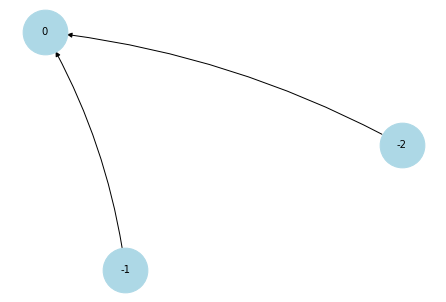

In [41]:
genome = Genome(1, n_inputs=2, n_outputs=1)
print(genome)
genome.visualize2()

In [42]:
def sum_aggregation(x):
    return sum(float(val) for val in x)

def max_aggregation(x):
    return max(float(val) for val in x)


def sigmoid_activation(z):
    z = max(-60.0, min(60.0, 5.0 * float(z)))
    return 1.0 / (1.0 + math.exp(-z))

def tanh_activation(z):
    z = max(-60.0, min(60.0, 2.5 * float(z)))
    return math.tanh(z)

class NEATConfig:
    def __init__(self, genome):
        self.genome_config = GenomeConfig(genome)

class GenomeConfig:
    def __init__(self, genome):
        self.input_keys = []
        self.output_keys = []
        
        for node in genome.nodes:
            if node.node_type == NodeType.INPUT:
                self.input_keys.append(str(node.node_id))
            elif node.node_type == NodeType.OUTPUT:
                self.output_keys.append(str(node.node_id))
                
        self.aggregation_function_defs = {
            'sum': sum_aggregation,  # Reference to the sum aggregation function
            'max': max_aggregation   # Example aggregation function
        }
        self.activation_defs = {
            'sigmoid': sigmoid_activation,  # Reference to the sigmoid activation function
            'tanh': tanh_activation         # Reference to the tanh activation function
        }

In [43]:
def fitness(genome,env):
    #genome.visualize()
    config = NEATConfig(genome)
    network = FeedForwardNetwork.create(genome, config)
    num_episodes = 10
    episode_durations = []

    for _ in range(num_episodes):
        state, info = env.reset()
        duration = 0
        done = False
        while not done:
            action_probs = network.activate(state)
            action = np.argmax(action_probs)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            duration += 1

        episode_durations.append(duration)
        
    genome.fitness = np.mean(episode_durations)
    return genome.fitness 


# Example usage
genome = Genome(1, n_inputs=4, n_outputs=2)  # Assuming 2 input nodes and 1 output node
print(fitness(genome,env))

10.3


In [44]:
def evolve(pop_size, max_generations, selection_size, env):

    c1 = 2
    c2 = 1
    c3 = 0.4
    compatibility_threshold = 0.5

    population = []  # List to hold genomes

    # Initialize the initial population
    for i in range(pop_size):
        genome = Genome(i, n_inputs=env.observation_space.shape[0], n_outputs=env.action_space.n)
        population.append(genome)

    # Evolution loop
    generation = 0
    child_number = pop_size

    while generation < max_generations:
        if generation %10 == 0:
            print(f"generation: {generation}")
        # Evaluate fitness for each genome
        for genome in population:
            fitness(genome, env)

        species_list = speciate(population, compatibility_threshold, c1, c2, c3)
        calculate_adjusted_fitness(species_list)

        # Update stagnation status and prune stagnant species
        for species in species_list:
            species.update_stagnation()

        species_list = prune_species(species_list, stagnation_threshold=15)

        offspring_counts = allocate_offspring(species_list, pop_size)

        new_population = []

        for species, offspring_count in zip(species_list, offspring_counts):
            parents = select_parents(species, offspring_count)

            for parent1, parent2 in parents:
                child_number += 1 
                child = Genome(child_number, n_inputs=env.observation_space.shape[0], n_outputs=env.action_space.n)
                child.crossover(parent1, parent2)  
                child.mutate()  
                new_population.append(child)

        generation += 1
        population = new_population

   
    for genome in population:
        fitness(genome, env)

    best_genome = max(population, key=lambda x: x.fitness)
    print(f"Best Genome ID: {best_genome.genome_id}, Fitness: {best_genome.fitness}")

    return best_genome


generation: 0
generation: 10
Best Genome ID: 402, Fitness: 500.0


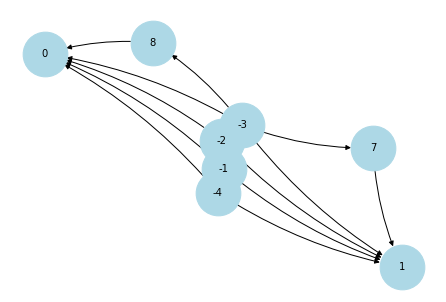

In [45]:
env = gym.make('CartPole-v1')
pop_size = 20
max_generations = 20
selection_size = 2  # Ensure selection_size <= pop_size

best_genome = evolve(pop_size, max_generations, selection_size, env)
best_genome.visualize()

In [46]:
from IPython.display import HTML, display, clear_output
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from tqdm import tqdm

In [47]:
def interactive_video(neural_network: object) -> None:
    """
    Creates an interactive video of the CartPole-v1 environment using a given neural network.
    This method might take a little long to run. Dont worry and let it run until the video is displayed :P
    
    Your provided Network should have 'env.observation_space.shape[0]' many inputs and 'env.action_space.n'
    many outputs. The action is choosen by an argmax over the output of the network.

    Args:
        neural_network (object): The neural network object to use for decision-making.

    Returns:
        None
    """
    # Check input
    assert neural_network is not None, f"Expected a class, but got {type(neural_network)}"
    assert (hasattr(neural_network, "activate") or hasattr(neural_network, "forward_pass") or hasattr(neural_network, "activate")), f"Expected a method 'forward', 'forward_pass' or 'activate' in the class. Make sure to name your method this way."
    
    env_name = "CartPole-v1"
    max_steps = 500
    
    # create the video
    %matplotlib notebook

    fig, ax = plt.subplots()


    env = gym.make(env_name, render_mode="rgb_array_list")
    state, _ = env.reset(seed=0)
    ims = []
    
    with tqdm(total=max_steps, position=0, leave=True) as pbar:
        for step_idx in range(max_steps):
            # adapt for different implementations
            action_probs = network.activate(state)
            action = np.argmax(action_probs)
            next_state, _, terminated, truncated, _ = env.step(action)
            state = next_state

            im = ax.imshow(env.render()[-1], animated=True)
            ims.append([im])

            if terminated or truncated:
                env.reset()
            
            if (step_idx < max_steps - 1):
                pbar.set_description(f'\033[94mℹ\033[0m Video progress {(step_idx + 1) / (max_steps / 100)}%')
            else:
                pbar.set_description(f'\033[94mℹ\033[0m Video rendered - creating Widget')
            pbar.update()
            
    env.close()
    clear_output(wait=True)
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

    plt.show()
    display(HTML(ani.to_jshtml()))

    %matplotlib inline

In [48]:
config = NEATConfig(genome)
network = FeedForwardNetwork.create(best_genome, config)
interactive_video(network)